In [ ]:

import gym
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from collections import deque
import time
import random

/usr/local/lib/python3.10/dist-packages/jaxlib/xla_client.py:225: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  float8_e4m3b11fnuz = ml_dtypes.float8_e4m3b11


In [ ]:
RANDOM_SEED = 5
tf.random.set_seed(RANDOM_SEED)

env = gym.make('CartPole-v1')
env.seed(seed=RANDOM_SEED)
np.random.seed(RANDOM_SEED)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym

In [ ]:
print("Action Space: {}".format(env.action_space))
print("State space: {}".format(env.observation_space))

Action Space: Discrete(2)
State space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


In [ ]:
# An episode a full game
train_episodes = 201
test_episodes = 100

In [ ]:
def agent(state_shape, action_shape):
    """ The agent maps X-states to Y-actions
    e.g. The neural network output is [.1, .7, .1, .3]
    The highest value 0.7 is the Q-Value.
    The index of the highest action (0.7) is action #1.
    """
    learning_rate = 0.001
    init = tf.keras.initializers.HeUniform()
    model = keras.Sequential()
    model.add(keras.layers.Dense(64, input_shape=state_shape, activation='relu', kernel_initializer=init))
    model.add(keras.layers.Dense(16, activation='relu', kernel_initializer=init))
    model.add(keras.layers.Dense(action_shape, activation='linear', kernel_initializer=init))
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])
    return model

In [ ]:
def get_qs(model, state, step):
    return model.predict(state.reshape([1, state.shape[0]]))[0]

In [ ]:
def train(env, replay_memory, model, target_model, done):
    learning_rate = 0.1 # Learning rate
    discount_factor = 0.95
    MIN_REPLAY_SIZE = 1000
    if len(replay_memory) < MIN_REPLAY_SIZE:
        return

    batch_size = 256
    mini_batch = random.sample(replay_memory, batch_size)
    current_states = np.array([transition[0] for transition in mini_batch])
    current_qs_list = model.predict(current_states)
    new_current_states = np.array([transition[3] for transition in mini_batch])
    future_qs_list = target_model.predict(new_current_states)
    X = []
    Y = []
    for index, (observation, action, reward, new_observation, done) in enumerate(mini_batch):
        if not done:
            max_future_q = reward + discount_factor * np.max(future_qs_list[index])
        else:
            max_future_q = reward

        current_qs = current_qs_list[index]
        current_qs[action] = (1 - learning_rate) * current_qs[action] + learning_rate * max_future_q

        X.append(observation)
        Y.append(current_qs)
    model.fit(np.array(X), np.array(Y), batch_size=batch_size, verbose=0, shuffle=True)

In [ ]:
Reward_tracker=[]
Episode_tracker=[]
Time_tracker=[]

In [ ]:
T0= time.time()/60
def main():
    epsilon = 1 # Epsilon-greedy algorithm in initialized at 1 meaning every step is random at the start
    max_epsilon = 1 # You can't explore more than 100% of the time
    min_epsilon = 0.01 # At a minimum, we'll always explore 1% of the time
    decay = 0.01

    # 1. Initialize the Target and Main models
    # Main Model (updated every 4 steps)
    model = agent(env.observation_space.shape, env.action_space.n)
    # Target Model (updated every 100 steps)
    # checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    # filepath='/content/drive/MyDrive/checkpoint.h5',  # Specify the file path to save the checkpoints
    # save_weights_only=True,  # Only save the model weights
    # save_best_only=True,  # Save only the best model based on a monitored metric
    # monitor='loss',  # Metric to monitor for saving the best model
    # mode='min'  # Mode of the monitored metric ('min', 'max', or 'auto')
    # )
    target_model = agent(env.observation_space.shape, env.action_space.n)
    target_model.set_weights(model.get_weights())

    replay_memory = deque(maxlen=10000)

    target_update_counter = 0

    # X = states, y = actions
    X = []
    y = []
    total_reward_10ep=0

    steps_to_update_target_model = 0
    #display = pyvirtualdisplay.Display(visible=False, size=(1400, 900))
    #display.start()

    for episode in range(train_episodes):
        total_training_rewards = 0
        observation = env.reset()
        done = False
        while not done:
            steps_to_update_target_model += 1
            #if True:
             #   env.render()

            random_number = np.random.rand()
            # 2. Explore using the Epsilon Greedy Exploration Strategy
            if random_number <= epsilon:
                # Explore
                action = env.action_space.sample()
            else:
                # Exploit best known action
                # model dims are (batch, env.observation_space.n)
                encoded = observation
                encoded_reshaped = encoded.reshape([1, encoded.shape[0]])
                predicted = model(encoded_reshaped).flatten()
                action = np.argmax(predicted)
            new_observation, reward, done, info = env.step(action)
            replay_memory.append([observation, action, reward, new_observation, done])

            # 3. Update the Main Network using the Bellman Equation
            if steps_to_update_target_model % 1 == 0 or done:
                train(env, replay_memory, model, target_model, done)

            observation = new_observation
            total_training_rewards += reward
            total_reward_10ep += reward


            if done:
                print('Total training rewards: {} after n steps = {} with final reward = {}'.format(total_training_rewards, episode, reward))
                total_training_rewards += 1

                if episode % 3 == 0:
                    # mean = total / 10
                    # print("Time Average: " + str(mean))
                    # total = 0
                    mean_reward = total_reward_10ep / 3
                    print("Mean Reward: " + str(mean_reward))
                    total_reward_10ep = 0
                    Reward_tracker.append(mean_reward)
                    Episode_tracker.append(episode)
                    T1= time.time()/60
                    Time_tracker.append(T1-T0)

                if steps_to_update_target_model >= 5:
                    print('Copying main network weights to the target network weights')
                    target_model.set_weights(model.get_weights())
                    steps_to_update_target_model = 0
                break


        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay * episode)
    env.close()
    #display.stop()

if __name__ == '__main__':
    main()

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer HeUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
8/8 [==============================] - 0s 3ms/step
Total training rewards: 310.0 after n steps = 135 with final reward = 1.0
Mean Reward: 229.0
Copying main network weights to the target network weights
8/8 [==============================] - 0s 3ms/step
Total training rewards: 270.0 after n steps = 136 with final reward = 1.0
Copying main network weights to the target network weights
8/8 [==============================] - 0s 3ms/step
Total training rewards: 312.0 after n steps = 137 with final reward = 1.0
Copying main network weights to the target network weights
8/8 [==============================] - 0s 3ms/step
Total training rewards: 69.0 after n steps = 138 with final reward = 1.0
Mean Reward: 217.0
Copying main network weights to the target network weights
8/8 [==============================] - 0s 3ms/step
Total training rewards: 224.0 after n steps = 139 with final reward = 1.0
Copying main network weights to the target network 

KeyboardInterrupt: ignored

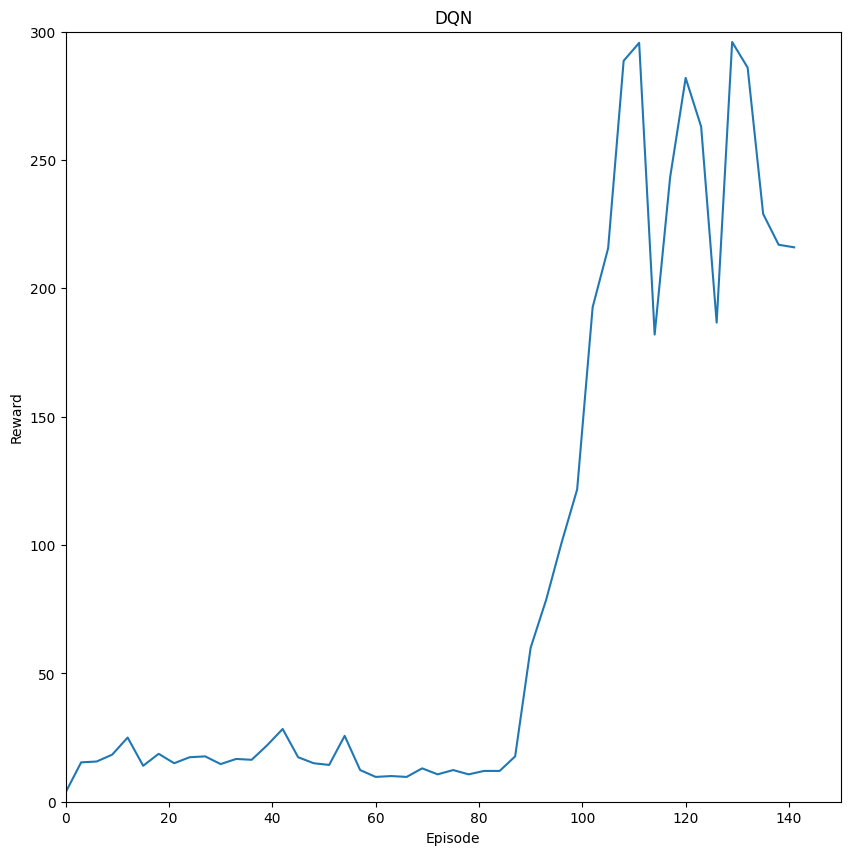

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(Episode_tracker,Reward_tracker)
plt.title("DQN")
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.ylim(0,300)
plt.xlim(0,150)
plt.show()

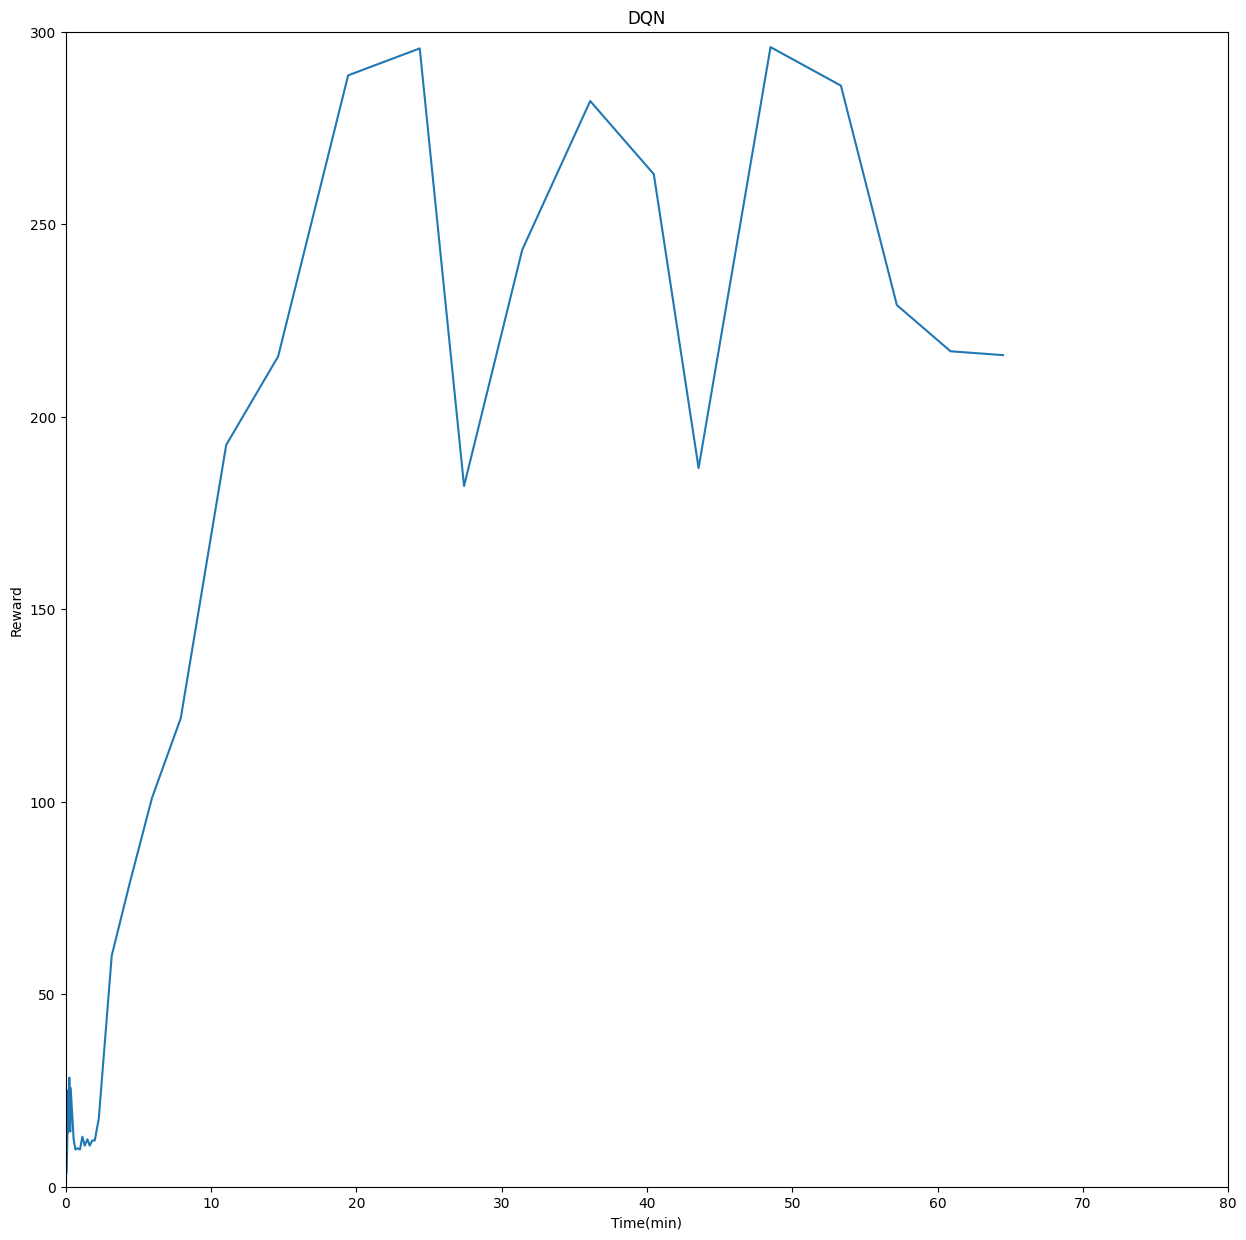

In [ ]:
plt.figure(figsize=(15,15))
plt.plot(Time_tracker,Reward_tracker)
plt.title("DQN")
plt.xlabel('Time(min)')
plt.ylabel('Reward')
plt.ylim(0,300)
plt.xlim(0,80)
plt.show()

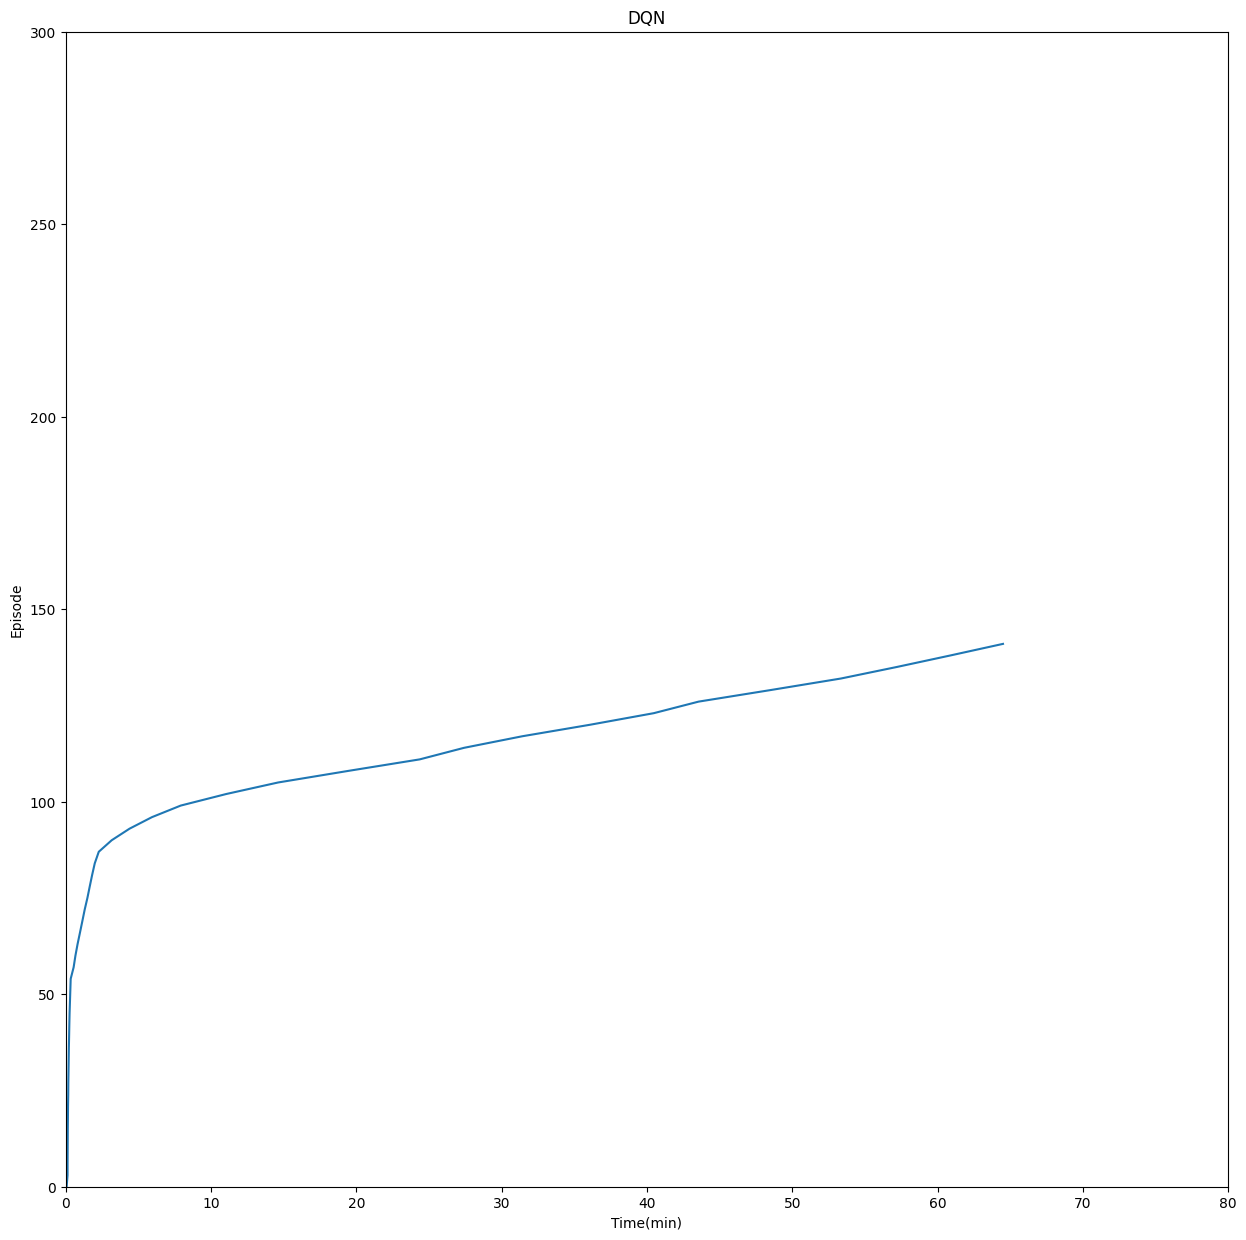

In [ ]:
plt.figure(figsize=(15,15))
plt.plot(Time_tracker,Episode_tracker)
plt.title("DQN")
plt.xlabel('Time(min)')
plt.ylabel('Episode')
plt.ylim(0,300)
plt.xlim(0,80)
plt.show()